# Cassava Plant Disease Classification
![](https://cff2.earth.com/uploads/2020/11/11065615/shutterstock_12823926312-scaled.jpg)

classifying 4 different types of diseases found in Cassava Plants through Tensorflow & Keras. 

The following topics will be covered:
1. Exploratory Data Analysis
2. Image Augmentation
3. Model Building and Selection
4. Stratified K-Fold Cross Validation
5. Model Ensembling and Inference

# Importing Libraries and Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
import os
import cv2
import sys
from pylab import rcParams
from PIL import Image
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Activation, Input, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.applications import InceptionV3, Xception
from tensorflow.keras.mixed_precision import experimental as mixed_precision
from sklearn.model_selection import StratifiedShuffleSplit

In [2]:
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_policy(policy) #shortens training time by 2x

First, let's take a look at our dataframe.

In [3]:
df_train = pd.read_csv("d:project/cassava-leaf-disease-classification/train.csv")
df_train.head()

image_id  label
0  1000015157.jpg      0
1  1000201771.jpg      3
2   100042118.jpg      1
3  1000723321.jpg      1
4  1000812911.jpg      3

In [4]:
df_train["label"] = df_train["label"].astype(str) #convert to str as we want to use Categorical Cross Entropy (CCE) later on
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21397 entries, 0 to 21396
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image_id  21397 non-null  object
 1   label     21397 non-null  object
dtypes: object(2)
memory usage: 334.5+ KB


# Exploratory Data Analysis

Now, we will take a look at the distribution of our data.

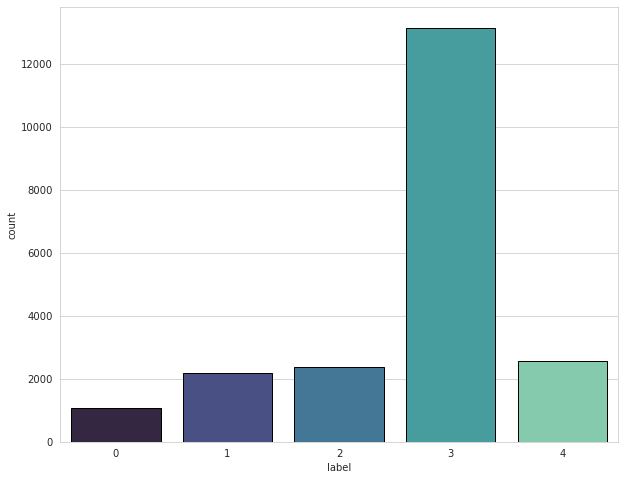

In [5]:
sns.set_style("whitegrid")
plt.figure(figsize=(10,8))
sns.countplot(df_train["label"], edgecolor="black", palette="mako")

From here, we can see that we have a highly unbalanced dataset. We have the largest number of samples for label 3, Cassava Mosiac Disease (CMD), and the fewest number of samples for label 0, Cassava Bacterial Blight (CBB). Let's visualize how some of these images look like next.

### Label 0: Cassava Bacterial Blight (CBB)

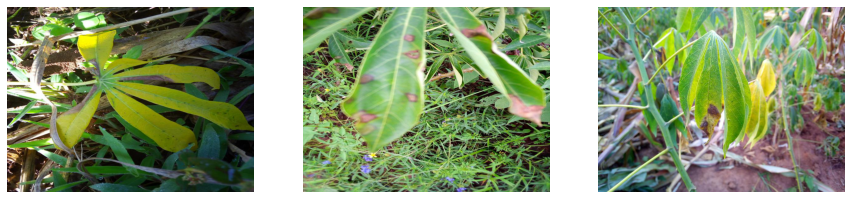

In [6]:
path = "d:project/cassava-leaf-disease-classification/train_images/"
df0 = df_train[df_train["label"] == "0"]
files = df0["image_id"].sample(3).tolist()

plt.figure(figsize=(15,5))
index = 0
for file in files:
    image = Image.open(path + file)
    plt.subplot(1, 3, index + 1)
    plt.imshow(image)
    plt.axis("off")
    index += 1

plt.show()

### Label 1: Cassava Brown Streak Disease (CBSD)

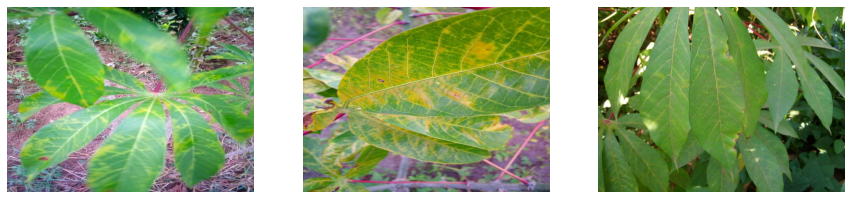

In [7]:
df1 = df_train[df_train["label"] == "1"]
files = df1["image_id"].sample(3).tolist()

plt.figure(figsize=(15,5))
index = 0
for file in files:
    image = Image.open(path + file)
    plt.subplot(1, 3, index + 1)
    plt.imshow(image)
    plt.axis("off")
    index += 1

plt.show()

### Label 2: Cassava Green Mottle (CGM)

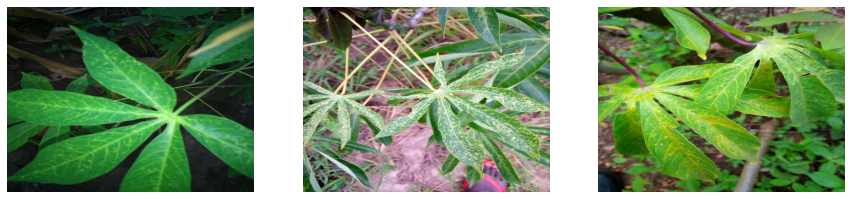

In [8]:
df2 = df_train[df_train["label"] == "2"]
files = df2["image_id"].sample(3).tolist()

plt.figure(figsize=(15,5))
index = 0
for file in files:
    image = Image.open(path + file)
    plt.subplot(1, 3, index + 1)
    plt.imshow(image)
    plt.axis("off")
    index += 1

plt.show()

### Label 3: Cassava Mosiac Disease (CMD)

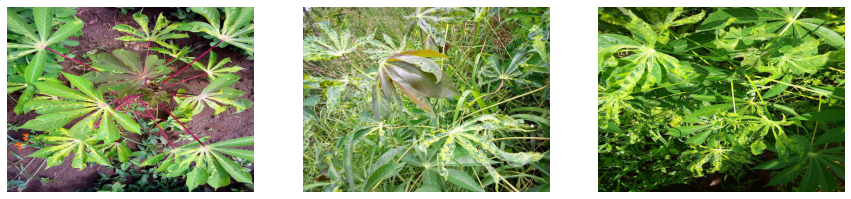

In [9]:
df3 = df_train[df_train["label"] == "3"]
files = df3["image_id"].sample(3).tolist()

plt.figure(figsize=(15,5))
index = 0
for file in files:
    image = Image.open(path + file)
    plt.subplot(1, 3, index + 1)
    plt.imshow(image)
    plt.axis("off")
    index += 1

plt.show()

### Label 4: Healthy

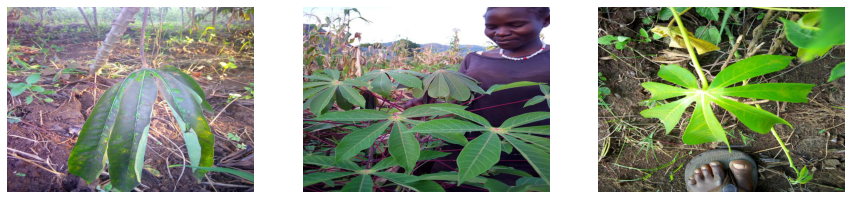

In [10]:
df4 = df_train[df_train["label"] == "4"]
files = df4["image_id"].sample(3).tolist()

plt.figure(figsize=(15,5))
index = 0
for file in files:
    image = Image.open(path + file)
    plt.subplot(1, 3, index + 1)
    plt.imshow(image)
    plt.axis("off")
    index += 1

plt.show()

Note that the images in this training set are "noisy". This means that there are some images that are mislabelled and hence will affect predictive performance. One of the basic ways to mitigate this is to use label smoothing on our loss metric, as you will see later on.

# Image Augmentation (Tensorflow)
Image augmentation is important as, with all Machine Learning problems, we do not want the model to "memorise" the training set. In this case, we do not want our algorithm to memorise features specific to the training images such as the orientation, position or shade of the cassava plant. Therefore, we need to augment the images so that the model is able to generalise well and not overfit to the training set.

One of the ways we can perform image augmentation is through Tensorflow preprocessing layers. They provide basic augmentations such as cropping, flipping and rotating.

In [11]:
batch_size=16
image_size=300

input_shape = (image_size, image_size, 3)
target_size = (image_size, image_size)

In [12]:
img_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.experimental.preprocessing.RandomCrop(image_size, image_size),
        tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.25),
        tf.keras.layers.experimental.preprocessing.RandomZoom((-0.25, 0.25), (-0.25, 0.25)),
    ])

Now let's see how an image looks like pre-augmentation and post-augmentation.

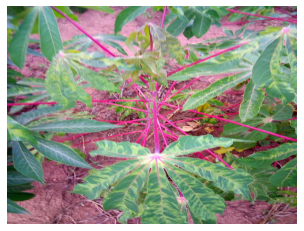

In [13]:
path = "D:Project/input/cassava-leaf-disease-classification/train_images/"
files = df_train["image_id"].tolist()
file = random.choice(files)
image = Image.open(path + file)
plt.imshow(image)
plt.axis("off")
plt.show()

Here are 9 possible outcomes after augmentation.

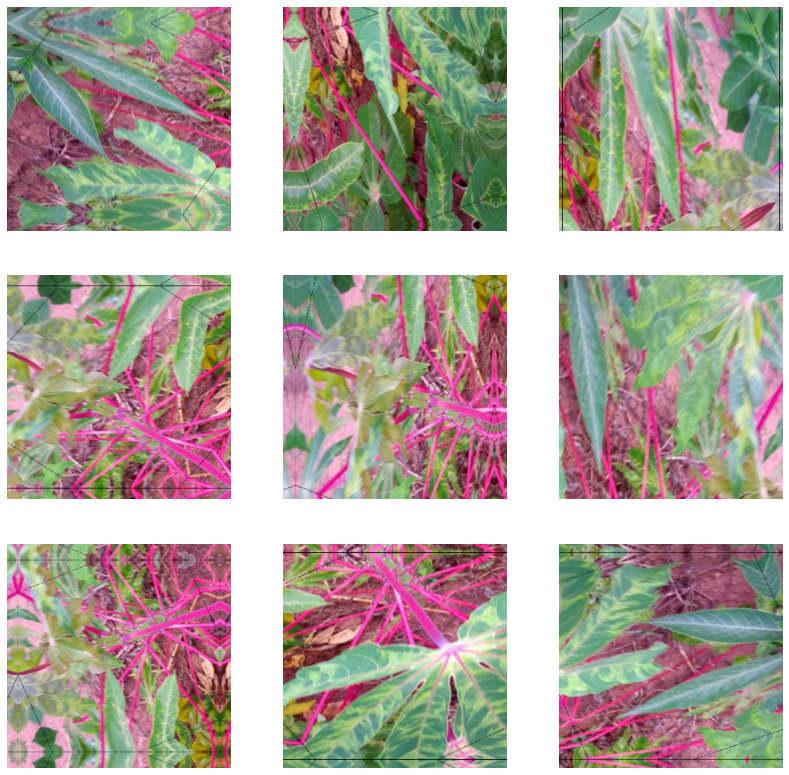

In [14]:
image = tf.expand_dims(np.array(image), 0)

plt.figure(figsize=(14, 14))
for i in range(9):
    augmented_image = img_augmentation(image)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image[0])
    plt.axis("off")

# Image Augmentation (Albumentations)
I will now show you how to perform image augmentations through Albumentation (an external image augmentation library with much more functionality) through both ImageDataGenerator. We will use a tool called ImageDataAugmentor (big thanks to mjkvaak at github) that allows us to do this.

In [15]:
!pip install git+https://github.com/mjkvaak/ImageDataAugmentor

  Cloning https://github.com/mjkvaak/ImageDataAugmentor to /tmp/pip-req-build-49prici8
  Created wheel for ImageDataAugmentor: filename=ImageDataAugmentor-0.0.0-py3-none-any.whl size=29530 sha256=a87562871f20e66729e331682bec8735ee400929e535f9a81b15ec9a93b588c1
  Stored in directory: /tmp/pip-ephem-wheel-cache-i1c7selx/wheels/c9/bd/73/9cfa59d2393dae55bbcc30f5aa901f55fe531c66efebbc8fc3
Successfully built ImageDataAugmentor
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [16]:
from ImageDataAugmentor.image_data_augmentor import *
import albumentations as A

train_augmentations = A.Compose([
            A.RandomCrop(image_size, image_size, p=1),
            A.CoarseDropout(p=0.5),
            A.Cutout(p=0.5),
            A.Flip(p=0.5),
            A.ShiftScaleRotate(p=0.5),
            A.HueSaturationValue(p=0.5, hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2),
            A.RandomBrightnessContrast(p=0.5, brightness_limit=(-0.2,0.2), contrast_limit=(-0.2, 0.2)),
            A.ToFloat()
            ], p=1)

val_augmentations = A.Compose([
                A.CenterCrop(image_size, image_size, p=1),
                A.ToFloat()
                ], p=1)

In [17]:
def TFDataGenerator(train_set, val_set):
    
    train_generator = ImageDataAugmentor(augment=train_augmentations)
    val_generator = ImageDataAugmentor(augment=val_augmentations)
    
    train_datagen = train_generator.flow_from_dataframe(
                  dataframe = train_set,
                  directory='d:project/cassava-leaf-disease-classification/train_images',
                  x_col='image_id',
                  y_col='label',
                  target_size=target_size,
                  batch_size=batch_size,
                  shuffle=True,
                  class_mode='categorical',
                  seed=2020)

    val_datagen = val_generator.flow_from_dataframe(
                dataframe = val_set,
                directory='d:project/cassava-leaf-disease-classification/train_images',
                x_col='image_id',
                y_col='label',
                target_size=target_size,
                batch_size=batch_size,
                shuffle=False,
                class_mode='categorical',
                seed=2020)
    
    return train_datagen, val_datagen

Now let's see how the generated images look like post-augmentation for our training set.

In [18]:
train_set = df_train.iloc[:10]
val_set = df_train.iloc[-10:]

train_datagen, val_datagen = TFDataGenerator(train_set, val_set)

Found 10 validated image filenames belonging to 5 classes.
Found 10 validated image filenames belonging to 4 classes.


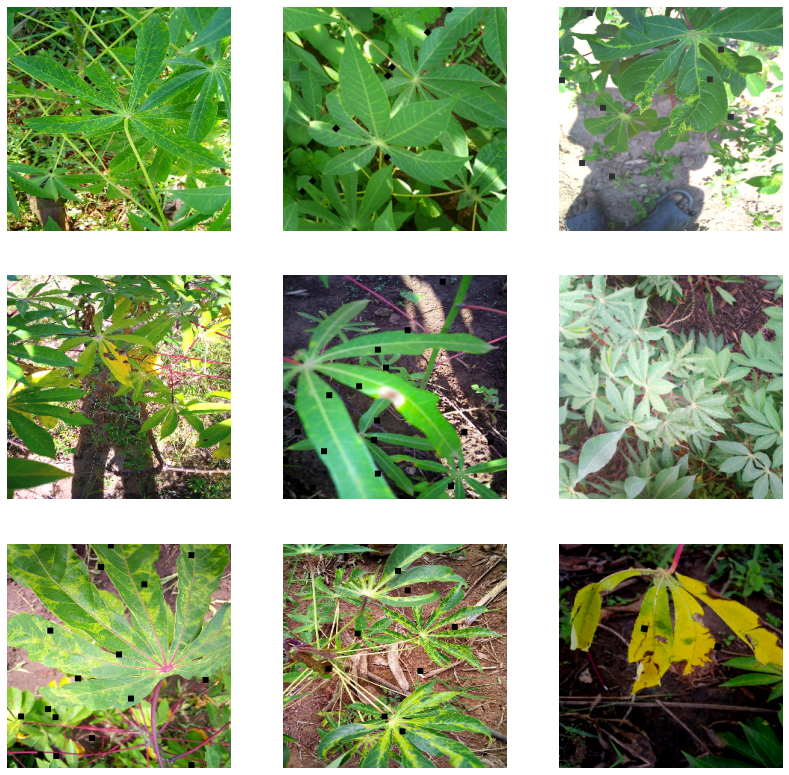

In [19]:
train_images, _ = next(train_datagen)

plt.figure(figsize=(14, 14))
for i in range(9):
    image = train_images[i]
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.axis("off")

plt.show()

And now our validation set:

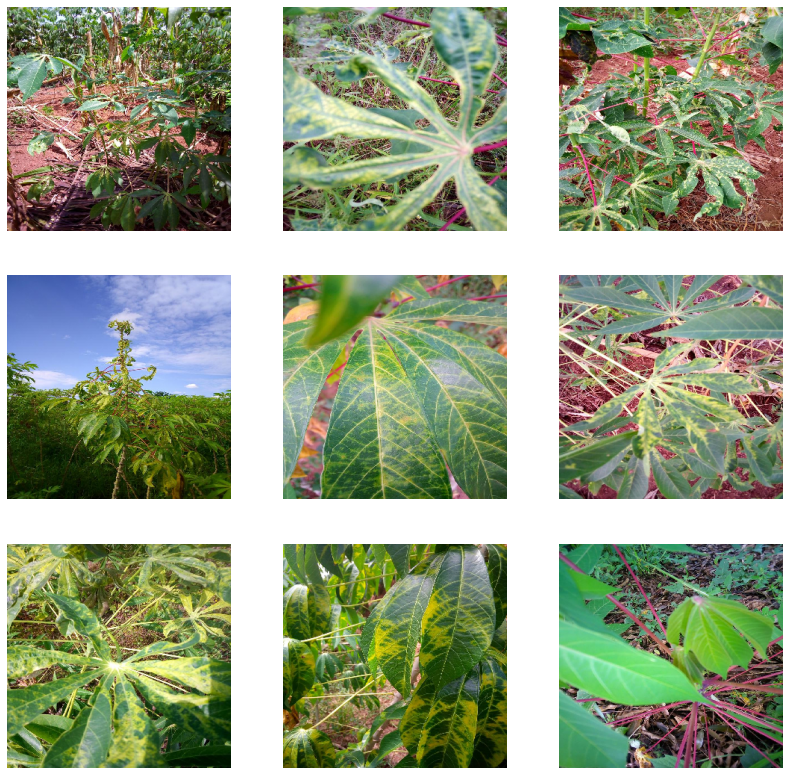

In [20]:
val_images, _ = next(val_datagen)

plt.figure(figsize=(14, 14))
for i in range(9):
    image = val_images[i]
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.axis("off")

plt.show()

# Model Building and Selection
Earlier on, I mentioned that to counter mislabelling, we would implement label smoothing on our loss metric (in this case, categorical cross-entropy). Here's how it works:

When we apply the cross-entropy loss to a classification task, we’re expecting true labels to be 1, while the others to be 0. In other words, we are sure that the labels are 100% correct. However, we already know that ***they are not!***

One way to circumvent this is to lower the confidence level of our labels. So instead of being 100% confident (or sure) that our labels are correct, we can be 90% or even 80% confident instead. This allows the model to "learn" that some the labels are not correct and make better predictions.

Originally, if an image is labelled "0" (Cassava Bacterial Blight Disease), the resulting one-hot label would be this: [1, 0, 0, 0, 0]. However, after applying label smoothing, then we get new one-hot labels according to this formula:

new_onehot_labels = onehot_labels * (1 - label_smoothing) + label_smoothing / num_classes

In our case, with a label smoothing value of 0.2, 

new_onehot_labels 

= [1, 0, 0, 0, 0] * (1 - 0.2) + 0.2 / 5

= [1, 0, 0, 0, 0] * 0.8 + 0.04

= [0.84, 0.04, 0.04, 0.04, 0.04]
                  
This means that we are ~84% confident in our labels!

In [21]:
def create_Inception():
    base_model = InceptionV3(include_top=False, weights="imagenet", input_shape=input_shape)

    # Rebuild top
    inputs = Input(shape=input_shape)

    model = base_model(inputs)
    pooling = GlobalAveragePooling2D()(model)
    dropout = Dropout(0.2)(pooling)

    outputs = Dense(5, activation="softmax", name="dense", dtype='float32')(dropout)

    # Compile
    inception = Model(inputs=inputs, outputs=outputs)
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
    loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2, from_logits=True)

    inception.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    return inception

In [22]:
def create_Xception():
    base_model = Xception(include_top=False, weights="imagenet", input_shape=input_shape)

    # Rebuild top
    inputs = Input(shape=input_shape)

    model = base_model(inputs)
    pooling = GlobalAveragePooling2D()(model)
    dropout = Dropout(0.2)(pooling)

    outputs = Dense(5, activation="softmax", name="dense", dtype='float32')(dropout)

    # Compile
    xception = Model(inputs=inputs, outputs=outputs)
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
    loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2, from_logits=True)

    xception.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    return xception

# Training with Stratified K-Fold Cross Validation
We need to train our models with k-fold cross validation to ensure that our model isn't overfitting on the training data (or rather, specific aspects of the training data). Stratified k-fold cv ensures that we have the same class representation in every fold. Here's a brief intuition:

![](https://scikit-learn.org/stable/_images/sphx_glr_plot_cv_indices_0041.png)

In our case, we take 90% of the train images for training and 10% for testing. However, this split can be arbitary. Moreover, we saw earlier on that the data is imbalanced. Typically, the class with the most images will be the easiest to predict as the model is able to train much better with more data. Hence, splitting the dataset randomly can cause huge variance in the model's performance. For example, on some splits, the model might get a validation subset that is easy to predict.. On others, it might get a difficult subset to predict.

By using stratified cross validation, we ensure that a different subset of the data is split into training and test sets every time. Additionally, we ensure that class representation remains the same for all subsets, thereby allocating equal difficulty in all subsets.

We will only do a stratified 3-fold cv this time due to time constraints.

In [23]:
fold_number = 0
n_splits = 3
epochs = 8

tf.keras.backend.clear_session()
sss = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.1, random_state=2020)
for train_index, val_index in sss.split(df_train["image_id"], df_train["label"]):
    train_set = df_train.loc[train_index]
    val_set = df_train.loc[val_index]
    train_datagen, val_datagen = TFDataGenerator(train_set, val_set)
    model = create_Inception()
    print("Training fold no.: " + str(fold_number+1))

    model_name = "inception "
    fold_name = "fold.h5"
    filepath = model_name + str(fold_number+1) + fold_name
    callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1, factor=0.2),
                 EarlyStopping(monitor='val_loss', patience=3),
                 ModelCheckpoint(filepath=filepath, monitor='val_loss', save_best_only=True)]

    history = model.fit(train_datagen, epochs=epochs, validation_data=val_datagen, callbacks=callbacks)
    fold_number += 1
    if fold_number == n_splits:
        print("Training finished!")

Found 19257 validated image filenames belonging to 5 classes.
Found 2140 validated image filenames belonging to 5 classes.
87916544/87910968 [==============================] - 1s 0us/step
Training fold no.: 1
Epoch 1/8
1204/1204 [==============================] - 405s 337ms/step - loss: 1.3094 - accuracy: 0.6885 - val_loss: 1.3280 - val_accuracy: 0.6640
Epoch 2/8
1204/1204 [==============================] - 300s 249ms/step - loss: 1.2410 - accuracy: 0.7748 - val_loss: 1.2519 - val_accuracy: 0.7593
Epoch 3/8
1204/1204 [==============================] - ETA: 0s - loss: 1.2266 - accuracy: 0.7931
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0019999999552965165.
1204/1204 [==============================] - 299s 248ms/step - loss: 1.2266 - accuracy: 0.7931 - val_loss: 1.3814 - val_accuracy: 0.5930
Epoch 4/8
1204/1204 [==============================] - 298s 247ms/step - loss: 1.1995 - accuracy: 0.8280 - val_loss: 1.1809 - val_accuracy: 0.8528
Epoch 5/8
1204/1204 [===============

In [26]:
fold_number = 0
n_splits = 3
epochs = 8

tf.keras.backend.clear_session()
sss = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.1, random_state=2020)
for train_index, val_index in sss.split(df_train["image_id"], df_train["label"]):
    train_set = df_train.loc[train_index]
    val_set = df_train.loc[val_index]
    train_datagen, val_datagen = TFDataGenerator(train_set, val_set)
    model = create_Xception()
    print("Training fold no.: " + str(fold_number+1))

    model_name = "xception "
    fold_name = "fold.h5"
    filepath = model_name + str(fold_number+1) + fold_name
    callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1, factor=0.2),
                 EarlyStopping(monitor='val_loss', patience=3),
                 ModelCheckpoint(filepath=filepath, monitor='val_loss', save_best_only=True)]

    history = model.fit(train_datagen, epochs=epochs, validation_data=val_datagen, callbacks=callbacks)
    fold_number += 1
    if fold_number == n_splits:
        print("Training finished!")

Found 19257 validated image filenames belonging to 5 classes.
Found 2140 validated image filenames belonging to 5 classes.
Training fold no.: 1
Epoch 1/8
1204/1204 [==============================] - 323s 268ms/step - loss: 1.3193 - accuracy: 0.6718 - val_loss: 1.2572 - val_accuracy: 0.7565
Epoch 2/8
1204/1204 [==============================] - 321s 266ms/step - loss: 1.2408 - accuracy: 0.7774 - val_loss: 1.2068 - val_accuracy: 0.8164
Epoch 3/8
1204/1204 [==============================] - 322s 267ms/step - loss: 1.2071 - accuracy: 0.8195 - val_loss: 1.1932 - val_accuracy: 0.8374
Epoch 4/8
1204/1204 [==============================] - ETA: 0s - loss: 1.1933 - accuracy: 0.8375
Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0019999999552965165.
1204/1204 [==============================] - 323s 268ms/step - loss: 1.1933 - accuracy: 0.8375 - val_loss: 1.2071 - val_accuracy: 0.8206
Epoch 5/8
1204/1204 [==============================] - 322s 267ms/step - loss: 1.1813 - accuracy: 0.8

# Model Ensembling and Inference
This is the part where you should take the code below into a separate inference notebook with minor code changes to the filepaths. Reason being that we needed the internet enabled to install ImageDataAugmentor but internet access is not allowed in this competition. 

In [76]:
models = []
for i in range(n_splits):
    inception = load_model("./inception " + str(i+1) + "fold.h5")
    models.append(inception)
    
for i in range(n_splits):
    xception = load_model("./xception " + str(i+1) + "fold.h5")
    models.append(xception)

In [77]:
ss = pd.read_csv(os.path.join('d:project/cassava-leaf-disease-classification', "sample_submission.csv"))
preds = []
results = []

for image_id in ss.image_id:
    image = Image.open(os.path.join('d:project/cassava-leaf-disease-classification', "test_images", image_id))
    image = image.resize((image_size, image_size))
    image = np.expand_dims(image, axis = 0)
    for model in models:
        preds.append(np.argmax(model.predict(image)))
    res = max(set(preds), key = preds.count)
    results.append(res)

ss['label'] = results
ss.to_csv('submission.csv', index = False)